In [67]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from joblib import dump
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from transformers import TimeSeriesTransformerModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from joblib import load
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [68]:
data = pd.read_csv('C:\\Users\\Vaibhav.Re\\Desktop\\Programs\\python\\algot\\data files\\1Min_data\\Options BANKNIFTY\\Expiry Wensday\\train2\\CNXBAN_2023-10-11_44000_CE.csv')

data['datetime'] = pd.to_datetime(data['datetime'])  # Convert to datetime
data['day'] = data['datetime'].dt.day
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute

data = data.drop(columns=['datetime', 'stock_code', 'exchange_code', 'product_type', 'expiry_date', 'right'])


X = data.drop(columns=['close'])
y = data['close']

# One-Hot Encoding of categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing for numerical data: impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Preprocess the data
X_processed = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Save the preprocessor
dump(preprocessor, 'preprocessor.joblib')


['preprocessor.joblib']

In [69]:
# 1. XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
dump(xgb_model, 'xgb_model.joblib')

# 2. LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
params = {'objective': 'regression', 'metric': 'mse'}
lgb_model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval])
dump(lgb_model, 'lgb_model.joblib')

# 3. CatBoost
cat_model = CatBoostRegressor(loss_function='RMSE', verbose=100)
cat_model.fit(X_train, y_train)
cat_model.save_model('cat_model.cbm')

# Prepare data for LSTM and GRU
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

# 4. LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=300, verbose=0)
lstm_model.save('lstm_model.h5')

# 5. GRU
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train_lstm, y_train, epochs=300, verbose=0)
gru_model.save('gru_model.h5')

# 6. Transformers
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# model = TimeSeriesTransformerModel.from_pretrained('huggingface/time-series-transformer')
# model.fit(X_scaled, y, epochs=20)
# model.save_pretrained('transformer_model')
# scaler_filename = "scaler.save"
# dump(scaler, scaler_filename)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 7
[LightGBM] [Info] Start training from score 379.894667
Learning rate set to 0.044928
0:	learn: 123.4666160	total: 2.62ms	remaining: 2.61s
100:	learn: 6.1914521	total: 184ms	remaining: 1.64s
200:	learn: 4.7086174	total: 354ms	remaining: 1.41s
300:	learn: 4.0760192	total: 608ms	remaining: 1.41s
400:	learn: 3.5960269	total: 797ms	remaining: 1.19s
500:	learn: 3.2456478	total: 960ms	remaining: 956ms
600:	learn: 2.9904327	total: 1.15s	remaining: 761ms
700:	learn: 2.7878559	total: 1.31s	remaining: 558ms
800:	learn: 2.6029707	total: 1.48s	remaining: 367ms
900:	learn: 2.4480685	total: 1.65s	remaining: 181ms
999:	learn: 2.3096158	total: 1.81s	remaining: 0us


c:\Users\Vaibhav.Re\.conda\envs\py38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [85]:
# Load models
xgb_model = load('xgb_model.joblib')
lgb_model = load('lgb_model.joblib')
cat_model = CatBoostRegressor()
cat_model.load_model('cat_model.cbm')
lstm_model = load_model('lstm_model.h5')
gru_model = load_model('gru_model.h5')
# transformer_model = TimeSeriesTransformerModel.from_pretrained('transformer_model')
# scaler = load("scaler.save")

data = pd.read_csv('C:\\Users\\Vaibhav.Re\\Desktop\\Programs\\python\\algot\\data files\\1Min_data\\Options BANKNIFTY\\Expiry Wensday\\train2\\CNXBAN_2023-10-11_44000_PE.csv')

data['datetime'] = pd.to_datetime(data['datetime'])  # Convert to datetime
data['day'] = data['datetime'].dt.day
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year
data['hour'] = data['datetime'].dt.hour
data['minute'] = data['datetime'].dt.minute

data = data.drop(columns=['datetime', 'stock_code', 'exchange_code', 'product_type', 'expiry_date', 'right'])


X = data.drop(columns=['close'])
y = data['close']

# One-Hot Encoding of categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing for numerical data: impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# Preprocess the data
X_processed = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)



# Get predictions from each model
xgb_pred = xgb_model.predict(X_test)
lgb_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
cat_pred = cat_model.predict(X_test)

# Prepare data for LSTM and GRU
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_pred = lstm_model.predict(X_test_lstm).flatten()
gru_pred = gru_model.predict(X_test_lstm).flatten()

# # Prepare data for Transformer
# X_test_scaled = scaler.transform(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))
# transformer_pred = transformer_model.predict(X_test_scaled).flatten()


meta_X = np.column_stack((xgb_pred, lgb_pred, cat_pred, lstm_pred, gru_pred))

# Hyperparameter tuning for meta-model
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.001,0.01, 0.1],
    'max_depth': [7,8,9]
}

# Combine predictions
# predictions = pd.DataFrame({
#     'xgb_pred': xgb_pred,
#     'lgb_pred': lgb_pred,
#     'cat_pred': cat_pred,
#     'lstm_pred': lstm_pred,
#     'gru_pred': gru_pred,
#     # 'transformer_pred': transformer_pred
# })

meta_model = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=meta_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(meta_X, y_test)
best_meta_model = grid_search.best_estimator_

# Final prediction
meta_pred = best_meta_model.predict(meta_X)


# Save models
dump(best_meta_model, 'best_meta_model.joblib')


# Evaluate the meta-model
mse_meta = mean_squared_error(y_test, meta_pred)
print(f'Meta-Model MSE: {mse_meta}')


15/15 [==============================] - 0s 2ms/step
Meta-Model MSE: 0.06055332421188972


In [86]:
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


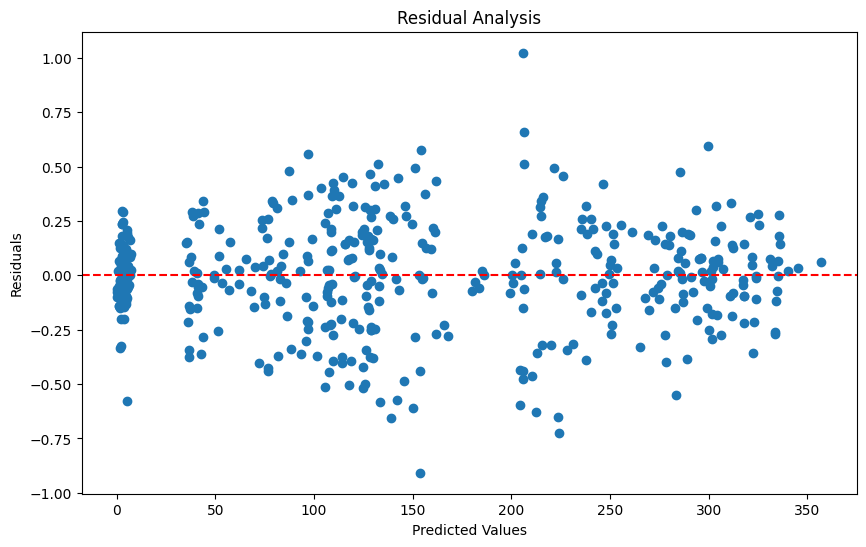

In [87]:

residuals = y_test - meta_pred
plt.figure(figsize=(10, 6))
plt.scatter(meta_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()


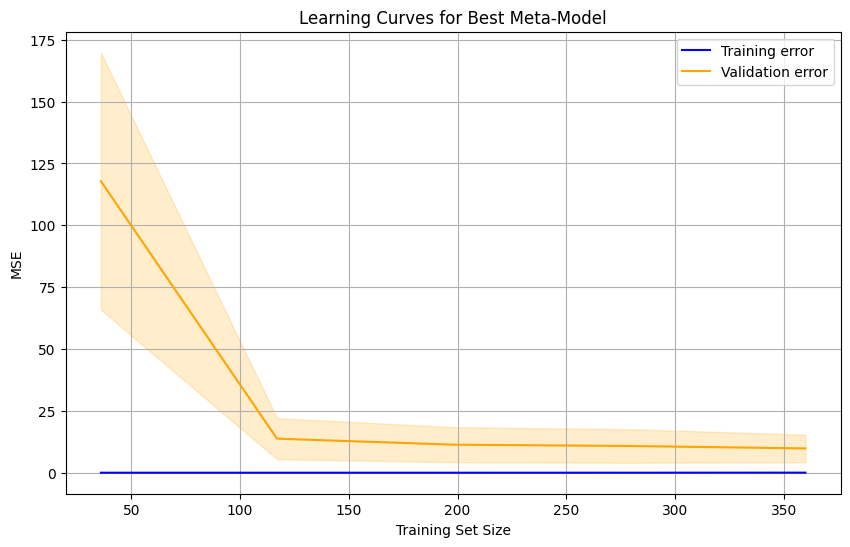

In [88]:


train_sizes, train_scores, test_scores = learning_curve(
    best_meta_model, meta_X, y_test, cv=5, scoring='neg_mean_squared_error'
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, color='blue', alpha=0.2)
plt.plot(train_sizes, test_scores_mean, label='Validation error', color='orange')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, color='orange', alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curves for Best Meta-Model')
plt.legend()
plt.grid(True)
plt.show()


In [89]:
# Load the models
xgb_model = load('xgb_model.joblib')
lgb_model = load('lgb_model.joblib')
cat_model = CatBoostRegressor()
cat_model.load_model('cat_model.cbm')
lstm_model = load_model('lstm_model.h5')
gru_model = load_model('gru_model.h5')
# transformer_model = TimeSeriesTransformerModel.from_pretrained('transformer_model')
# scaler = load('scaler.save')
best_meta_model = load('best_meta_model.joblib')

# Example prediction workflow
def predict_new_data(new_data):
    # Preprocess new data
    new_data_processed = scaler.transform(new_data)
    
    # Get predictions from each model
    xgb_pred = xgb_model.predict(new_data_processed)
    lgb_pred = lgb_model.predict(new_data_processed, num_iteration=lgb_model.best_iteration)
    cat_pred = cat_model.predict(new_data_processed)

    # Prepare data for LSTM and GRU
    new_data_lstm = np.array(new_data_processed).reshape((new_data_processed.shape[0], 1, new_data_processed.shape[1]))
    lstm_pred = lstm_model.predict(new_data_lstm).flatten()
    gru_pred = gru_model.predict(new_data_lstm).flatten()

    # Prepare data for Transformer
    new_data_scaled = new_data_processed.reshape((new_data_processed.shape[0], 1, new_data_processed.shape[1]))
    # transformer_pred = transformer_model.predict(new_data_scaled).flatten()

    # Combine predictions
    predictions = np.column_stack((xgb_pred, lgb_pred, cat_pred, lstm_pred, gru_pred, transformer_pred))

    # Get final prediction from meta-model
    final_pred = best_meta_model.predict(predictions)
    
    return final_pred

# Load new data
# new_data = pd.read_csv('path_to_new_data.csv')
# final_predictions = predict_new_data(new_data)
# print(final_predictions)

In [ ]:
from fyers_apiv3.FyersWebsocket import data_ws


def onmessage(message):
    """
    Callback function to handle incoming messages from the FyersDataSocket WebSocket.

    Parameters:
        message (dict): The received message from the WebSocket.

    """
    def data_handler(message):
        #preprocessing data
        return message
    data=data_handler(message)
    predicted_data=predict_new_data(data)
    
    print("Response:", predicted_data)


def onerror(message):
    print("Error:", message)


def onclose(message):
    
    print("Connection closed:", message)


def onopen():
    """
    Callback function to subscribe to data type and symbols upon WebSocket connection.

    """
    # Specify the data type and symbols you want to subscribe to
    data_type = "SymbolUpdate"

    # Subscribe to the specified symbols and data type
    symbols = ['NSE:NIFTYBANK-INDEX']
    wfyers.subscribe(symbols=symbols, data_type=data_type)

    # Keep the socket running to receive real-time data
    wfyers.keep_running()


# Replace the sample access token with your actual access token obtained from Fyers
access_token = f"{client_id}:{token}"

# Create a FyersDataSocket instance with the provided parameters
wfyers = data_ws.FyersDataSocket(
    access_token=access_token,       # Access token in the format "appid:accesstoken"
    log_path="",                     # Path to save logs. Leave empty to auto-create logs in the current directory.
    litemode=True,                  # Lite mode disabled. Set to True if you want a lite response.
    write_to_file=False,              # Save response in a log file instead of printing it.
    reconnect=True,                  # Enable auto-reconnection to WebSocket on disconnection.
    on_connect=onopen,               # Callback function to subscribe to data upon connection.
    on_close=onclose,                # Callback function to handle WebSocket connection close events.
    on_error=onerror,                # Callback function to handle WebSocket errors.
    on_message=onmessage             # Callback function to handle incoming messages from the WebSocket.
)

# Establish a connection to the Fyers WebSocket
wfyers.connect()
